In [47]:
import numpy as np
import matplotlib.pyplot as plt
import unyt as u
from unyt import mp
from scipy.integrate import quad, cumtrapz
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fmin, minimize

In [2]:
H_0=70*u.km/u.s/u.Mpc
a_0=(u.c*H_0).in_base("galactic").v
G=u.G.in_base("galactic").v
c=u.c.value

In [28]:
radii=np.logspace(np.log10(1),np.log10(2000.0),100)
num_points = radii.size

In [ ]:
i = np.searchsorted(radii, )

In [4]:
def make_beta_func(rho_c, r_c, r_s, alpha, beta, epsilon, gamma=3.0):
    return lambda r: (rho_c*((r/r_c)**(-alpha/2.))*((1.+(r/r_c)**2)**(-3.*beta/2.0+alpha/4.0)))*(1.0/(1.0+(r/r_s)**gamma)**(0.5*epsilon/gamma))

In [5]:
def make_beta_func_2(rho_c, r_c, r_s, alpha, beta, epsilon, rho_c2, r_c2, beta_2, gamma=3.0):
    return lambda r: np.sqrt((rho_c**2*((r/r_c)**(-alpha))*((1.+(r/r_c)**2)**(-3.*beta+alpha/2.0)))*(1.0/(1.0+(r/r_s)**gamma)**(epsilon/gamma)) + ((rho_c2**2)/(1+(r**2)/(r_c2**2))**(3*beta_2)))

In [6]:
def make_rho_c(n_0):
    rho_c = 1.252*mp*n_0*u.cm**-3
    return rho_c.to_value("Msun/kpc**3")

In [7]:
def integrate_mass(func):
    n_radii=radii.size
    integrand=lambda rr: func(rr)*rr*rr
    masses=np.zeros(radii.size)
    for i in range(n_radii):
        masses[i]=4.0*np.pi*quad(integrand, 0.0, radii[i])[0]
    return masses

In [8]:
def EG_mass(radii, rho_B, M_B):
    return np.sqrt((a_0*radii**2/(6*G))*(M_B+(4*np.pi*radii**3*rho_B)))

In [9]:
def EG_density(EG_mass):
    f = InterpolatedUnivariateSpline(radii, EG_mass)
    rho = f(radii, nu=1)/(4.0*np.pi*radii**2)
    return rho

In [10]:
def make_temp_func(T_0, T_min, r_t, r_cool, a, b, c, a_cool):
    def _temp(r):
        t = (r/r_t)**(-a)/(1.0+(r/r_t)**b)**(c/b)
        x = (r/r_cool)**a_cool
        t_cool = (x+T_min/T_0)/(x+1)
        return T_0*t*t_cool
    return _temp

In [11]:
def M_hse(r_arr, rho_arr, T_arr):
    rho_f = InterpolatedUnivariateSpline(r_arr, rho_arr, k=5)
    T_f = InterpolatedUnivariateSpline(r_arr, T_arr, k=5)
    dlogrho = rho_f(r_arr, nu=1)*r_arr/rho_arr
    dlogT = T_f(r_arr, nu=1)*r_arr/T_arr
    # The 1.0e-3 factor below is because the radii need to be in Mpc
    return -3.68e13*T_arr*(1.0e-3*r_arr)*(dlogrho+dlogT)

In [12]:
def rho_hse(M_arr):
    f = InterpolatedUnivariateSpline(radii, M_arr)
    rho = f(radii, nu=1)/(4.0*np.pi*radii**2)
    return rho

In [13]:
def diff(HSE, EG):
    return(HSE - EG)

In [53]:
def make_root_finder(mtot, m_b, rho_b):
    def _y(x, i):
        #m_b = trapz(4.0*np.pi*rho_b*radius**2, radius, initial=0.0)
        rho_b[i] = x
        if i == 0:
            dr = radii[i]
            m_b[i] = 4.0*np.pi*0.5*radii[i]**2*rho_b[i]*dr
        else:
            dr = radii[i]-radii[i-1]
            m_b[i] = 4.0*np.pi*0.5*(radii[i-1]**2*rho_b[i-1]+radii[i]**2*rho_b[i])*dr+m_b[i-1]
        y = mtot[i] - m_b[i] - np.sqrt(a_0/(6.0*G))*radii[i]*np.sqrt(m_b[i]+4.0*np.pi*radii[i]**3*rho_b[i])
        return y
    return _y

In [15]:
# A262

rho_c_262 = make_rho_c(3.434e-3)
r_c_262 = 45.2
r_s_262 = 350.8
alpha_262 = 1.674
beta_262 = 0.333
epsilon_262 = 1.806
r_t_262 = 0.35e3
r_cool_262 = 19.0
a_262 = -0.02
b_262 = 5.0
c_262 = 1.1
a_cool_262 = 5.25
T_0_262 = 2.42
T_min_262 = 0.64*T_0_262
r_min_262 = 10
r_det_262 = 450

In [18]:
beta_func_262 = make_beta_func(rho_c_262, r_c_262, r_s_262, alpha_262, beta_262, epsilon_262)
temp_func_262 = make_temp_func(T_0_262, T_min_262, r_t_262, r_cool_262, a_262, b_262, c_262, a_cool_262)
M_B_262 = integrate_mass(beta_func_262)
rho_B_262 = beta_func_262(radii)
M_DM_262 = EG_mass(radii, rho_B_262, M_B_262)
rho_DM_262 = EG_density(M_DM_262)
rho_total_262 = rho_B_262 + rho_DM_262
M_total_262 = M_B_262 + M_DM_262
f_gEG_262 = M_B_262 / M_total_262
temp_262 = temp_func_262(radii)
M_HSE_262 = M_hse(radii, rho_B_262, temp_262)
f_gHSE_262 = M_B_262 / M_HSE_262
rho_HSE_262 = rho_hse(M_HSE_262)
M_diff_262 = diff(M_HSE_262, M_total_262)
rho_diff_262 = diff(rho_HSE_262, rho_total_262)

(10, 450)

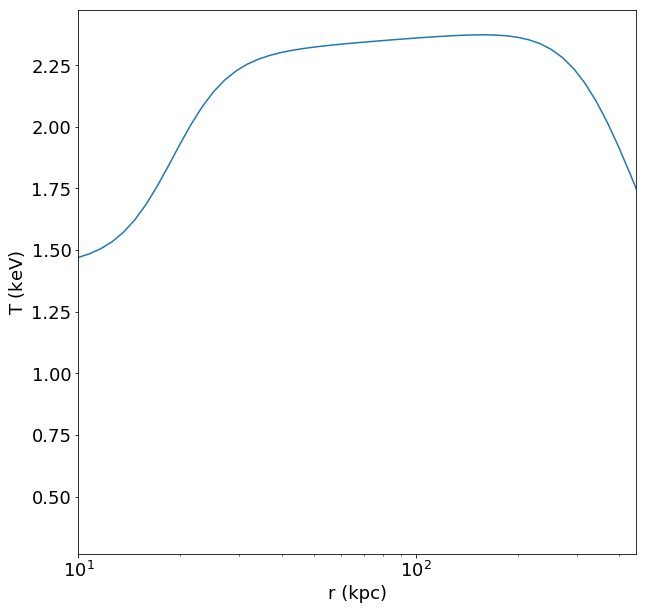

In [19]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_262)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_262, r_det_262)

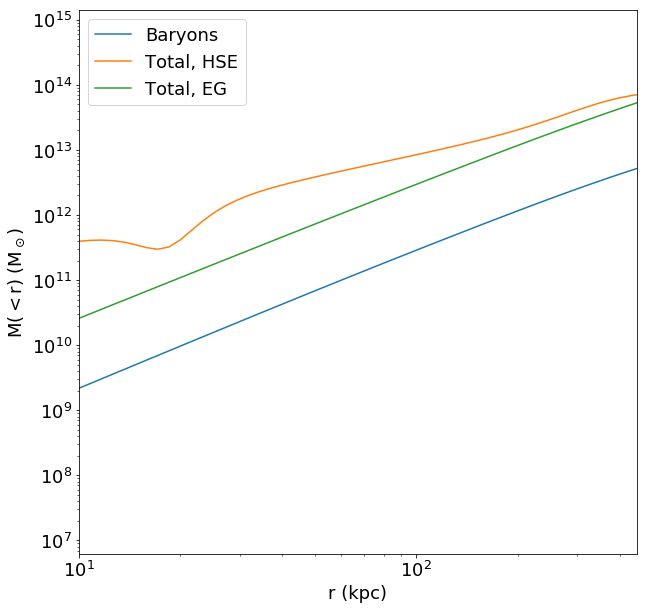

In [20]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_262, label="Baryons")
plt.loglog(radii, M_HSE_262, label="Total, HSE")
plt.loglog(radii, M_total_262, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_262, r_det_262)
plt.legend()

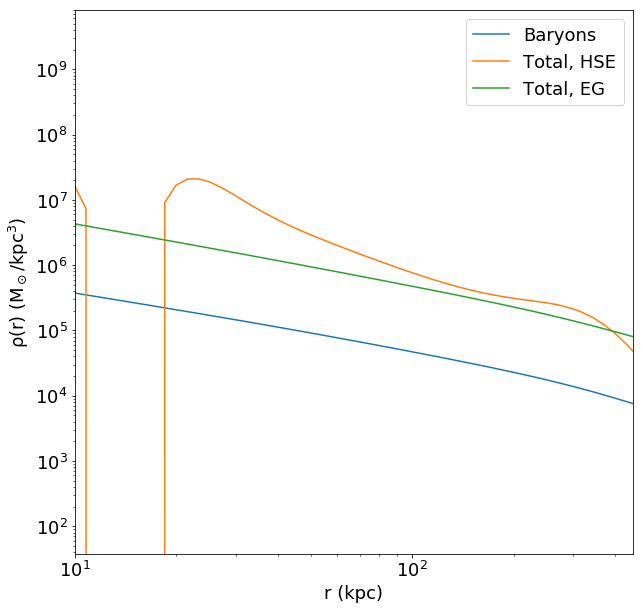

In [21]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_262, label="Baryons")
plt.loglog(radii, rho_HSE_262, label="Total, HSE")
plt.loglog(radii, rho_total_262, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_262, r_det_262)
plt.legend()

(0, 0.2)

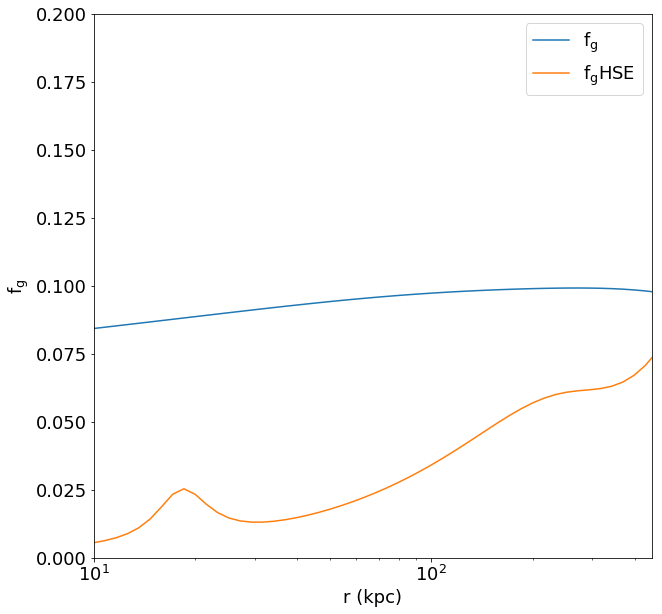

In [22]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_262, label = "$\mathrm{f_g}$")
plt.plot(radii, f_gHSE_262, label = "$\mathrm{f_gHSE}$")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_262, r_det_262)
plt.xscale("log")
plt.legend()
plt.ylim(0, 0.2)

(10, 450)

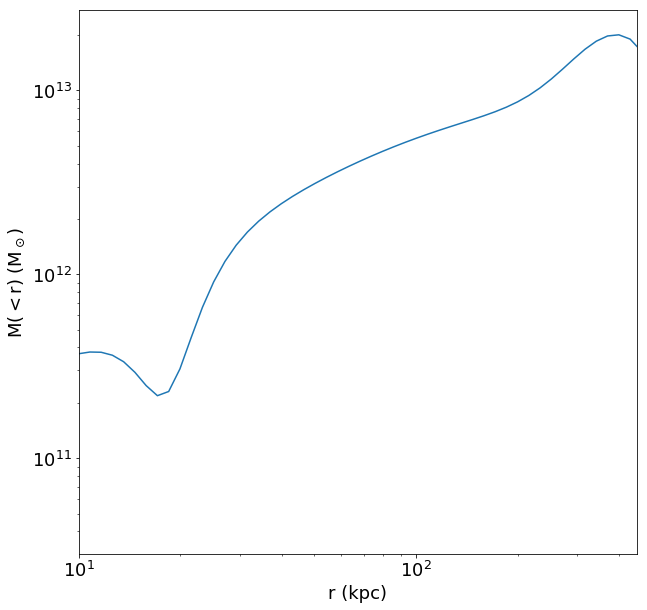

In [23]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_262)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_262, r_det_262)

Text(0, 0.5, '$\\mathrm{\\rho(r)\\ (M_\\odot/kpc^3)}$')

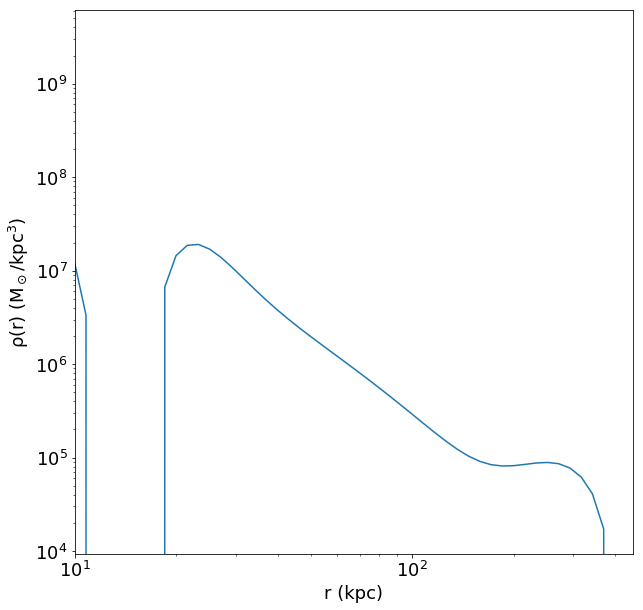

In [24]:
plt.rc("font", size = 18)
plt.figure(figsize = (10,10))
plt.loglog(radii, rho_diff_262)
plt.xlim(r_min_262, r_det_262)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")

In [25]:
#A907

rho_c_907 = make_rho_c(6.257e-3)
r_c_907 = 136.9
r_s_907 = 1885.1
alpha_907 = 1.554
beta_907 = 0.594
epsilon_907 = 4.986
r_t_907 = 0.24e3
r_cool_907 = 208
a_907 = 0.16
b_907 = 5.00
c_907 = 0.4
a_cool_907 = 1.48
T_0_907 = 10.19
T_min_907 = 0.32*T_0_907
r_min_907 = 40
r_det_907 = 1300

In [26]:
beta_func_907 = make_beta_func(rho_c_907, r_c_907, r_s_907, alpha_907, beta_907, epsilon_907)
temp_func_907 = make_temp_func(T_0_907, T_min_907, r_t_907, r_cool_907, a_907, b_907, c_907, a_cool_907)
M_B_907 = integrate_mass(beta_func_907)
rho_B_907 = beta_func_907(radii)
M_DM_907 = EG_mass(radii, rho_B_907, M_B_907)
rho_DM_907 = EG_density(M_DM_907)
rho_total_907 = rho_B_907 + rho_DM_907
M_total_907 = M_B_907 + M_DM_907
f_gEG_907 = M_B_907 / M_total_907
temp_907 = temp_func_907(radii)
M_HSE_907 = M_hse(radii, rho_B_907, temp_907)
f_gHSE_907 = M_B_907 / M_HSE_907
rho_HSE_907 = rho_hse(M_HSE_907)
M_diff_907 = diff(M_HSE_907, M_total_907)
rho_diff_907 = diff(rho_HSE_907, rho_total_907)

In [77]:
M_B_EG_907 = np.zeros(M_total_907.size)
rho_B_EG_907 = np.zeros(M_total_907.size)
M907_rf = make_root_finder(M_total_907, M_B_EG_907, rho_B_EG_907)

In [78]:
for i in range(num_points):
    out = minimize(M907_rf, rho_B_907[i], args=(i,), method="Nelder-Mead")

(40, 1300)

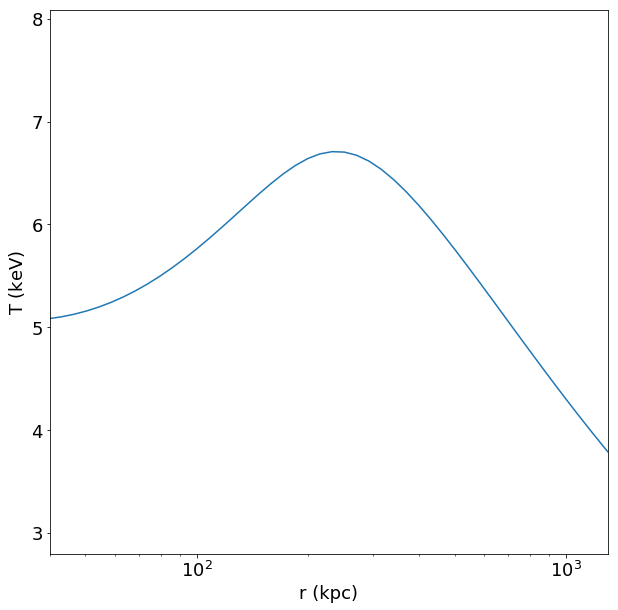

In [80]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_907)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_907, r_det_907)

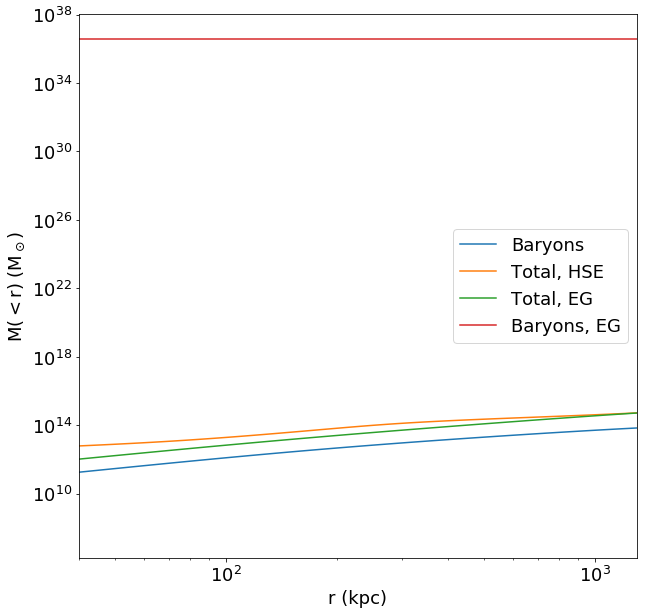

In [81]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_907, label="Baryons")
plt.loglog(radii, M_HSE_907, label="Total, HSE")
plt.loglog(radii, M_total_907, label="Total, EG")
plt.loglog(radii, M_B_EG_907, label='Baryons, EG')
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_907, r_det_907)
plt.legend()

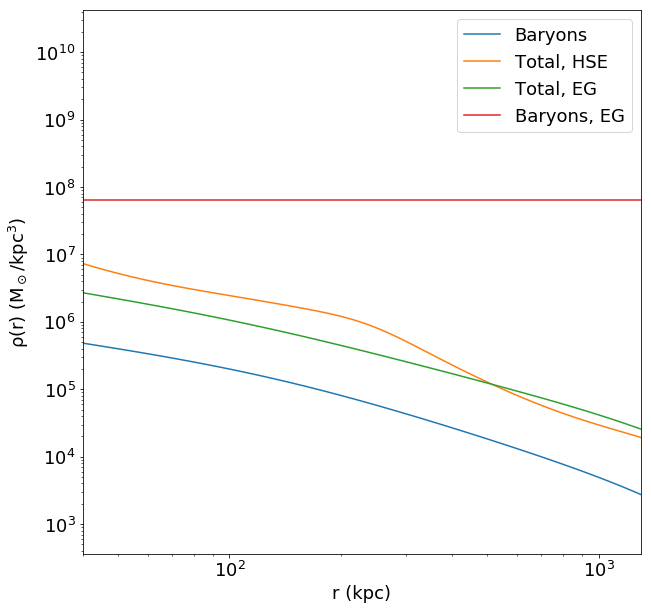

In [70]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_907, label="Baryons")
plt.loglog(radii, rho_HSE_907, label="Total, HSE")
plt.loglog(radii, rho_total_907, label="Total, EG")
plt.loglog(radii, rho_B_EG_907, label='Baryons, EG')
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_907, r_det_907)
plt.legend()

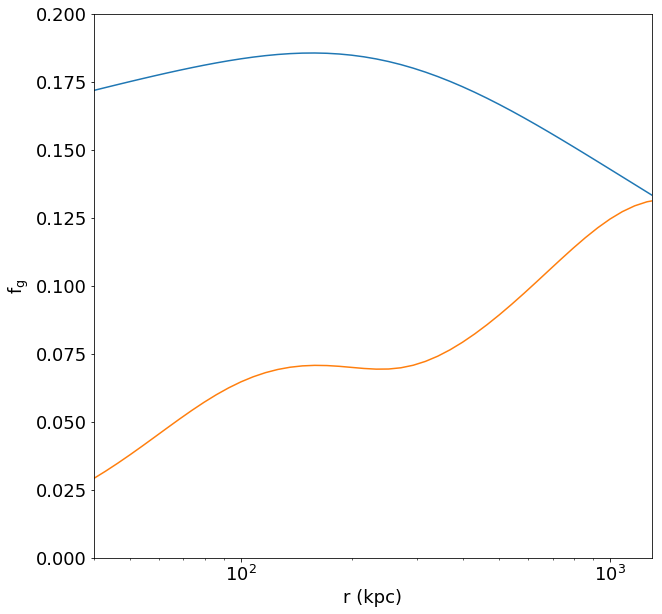

In [71]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_907)
plt.plot(radii, f_gHSE_907)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xscale("log")
plt.xlim(r_min_907, r_det_907)
plt.ylim(0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_907)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_907, r_det_907)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_907)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_907, r_det_907)

In [ ]:
#A1413

rho_c_1413 = make_rho_c(5.526e-3)
r_c_1413 = 186.3
r_s_1413 = 2077.1
alpha_1413 = 1.217
beta_1413 = 0.651
epsilon_1413 = 4.991
r_t_1413 = 1.84e3
r_cool_1413 = 30
a_1413 = 0.08
b_1413 = 4.68
c_1413 = 10.0
a_cool_1413 = 0.75
T_0_1413 = 7.58
T_min_1413 = 0.23*T_0_1413
r_min_1413 = 20
r_det_1413 = 1800

In [ ]:
beta_func_1413 = make_beta_func(rho_c_1413, r_c_1413, r_s_1413, alpha_1413, beta_1413, epsilon_1413)
temp_func_1413 = make_temp_func(T_0_1413, T_min_1413, r_t_1413, r_cool_1413, a_1413, b_1413, c_1413, a_cool_1413)
M_B_1413 = integrate_mass(beta_func_1413)
rho_B_1413 = beta_func_1413(radii)
M_DM_1413 = EG_mass(radii, rho_B_1413, M_B_1413)
rho_DM_1413 = EG_density(M_DM_1413)
rho_total_1413 = rho_B_1413 + rho_DM_1413
M_total_1413 = M_B_1413 + M_DM_1413
f_gEG_1413 = M_B_1413 / M_total_1413
temp_1413 = temp_func_1413(radii)
M_HSE_1413 = M_hse(radii, rho_B_1413, temp_1413)
f_gHSE_1413 = M_B_1413 / M_HSE_1413
rho_HSE_1413 = rho_hse(M_HSE_1413)
M_diff_1413 = diff(M_HSE_1413, M_total_1413)
rho_diff_1413 = diff(rho_HSE_1413, rho_total_1413)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_1413)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_1413, r_det_1413)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_1413, label="Baryons")
plt.loglog(radii, M_HSE_1413, label="Total, HSE")
plt.loglog(radii, M_total_1413, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1413, r_det_1413)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_1413, label="Baryons")
plt.loglog(radii, rho_HSE_1413, label="Total, HSE")
plt.loglog(radii, rho_total_1413, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1413, r_det_1413)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_1413)
plt.plot(radii, f_gHSE_1413)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_1413, r_det_1413)
plt.ylim(0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_1413)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1413, r_det_1413)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_1413)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1413, r_det_1413)

In [ ]:
#A1795

rho_c_1795 = make_rho_c(14.993e-3)
r_c_1795 = 72.8
r_s_1795 = 1030.8
alpha_1795 = 1.060
beta_1795 = 0.545
epsilon_1795 = 3.474
r_t_1795 = 0.55e3
r_cool_1795 = 77.0
a_1795 = 0.00
b_1795 = 1.63
c_1795 = 0.9
a_cool_1795 = 1.03
T_0_1795 = 9.68
T_min_1795 = 0.10*T_0_1795
r_min_1795 = 40
r_det_1795 = 1500

In [ ]:
beta_func_1795 = make_beta_func(rho_c_1795, r_c_1795, r_s_1795, alpha_1795, beta_1795, epsilon_1795)
temp_func_1795 = make_temp_func(T_0_1795, T_min_1795, r_t_1795, r_cool_1795, a_1795, b_1795, c_1795, a_cool_1795)
M_B_1795 = integrate_mass(beta_func_1795)
rho_B_1795 = beta_func_1795(radii)
M_DM_1795 = EG_mass(radii, rho_B_1795, M_B_1795)
rho_DM_1795 = EG_density(M_DM_1795)
rho_total_1795 = rho_B_1795 + rho_DM_1795
M_total_1795 = M_B_1795 + M_DM_1795
f_gEG_1795 = M_B_1795 / M_total_1795
temp_1795 = temp_func_1795(radii)
M_HSE_1795 = M_hse(radii, rho_B_1795, temp_1795)
f_gHSE_1795 = M_B_1795 / M_HSE_1795
rho_HSE_1795 = rho_hse(M_HSE_1795)
M_diff_1795 = diff(M_HSE_1795, M_total_1795)
rho_diff_1795 = diff(rho_HSE_1795, rho_total_1795)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_1795)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_1795, r_det_1795)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_1795, label="Baryons")
plt.loglog(radii, M_HSE_1795, label="Total, HSE")
plt.loglog(radii, M_total_1795, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.legend()
plt.xlim(r_min_1795, r_det_1795)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_1795, label="Baryons")
plt.loglog(radii, rho_HSE_1795, label="Total, HSE")
plt.loglog(radii, rho_total_1795, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.legend()
plt.xlim(r_min_1795, r_det_1795)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_1795)
plt.plot(radii, f_gHSE_1795)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_1795, r_det_1795)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_1795)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1795, r_det_1795)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_1795)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1795, r_det_1795)

In [ ]:
#A2390

rho_c_2390 = make_rho_c(3.069e-3)
r_c_2390 = 353.6
r_s_2390 = 1200.0
alpha_2390 = 1.917
beta_2390 = 0.696
epsilon_2390 = 0.240
r_t_2390 = 2.46e3
r_cool_2390 = 214
a_2390 = -0.10
b_2390 = 5.00
c_2390 = 10.0
a_cool_2390 = 0.08
T_0_2390 = 19.34
T_min_2390 = 0.12*T_0_2390
r_min_2390 = 80
r_det_2390 = 2500

In [ ]:
beta_func_2390 = make_beta_func(rho_c_2390, r_c_2390, r_s_2390, alpha_2390, beta_2390, epsilon_2390)
temp_func_2390 = make_temp_func(T_0_2390, T_min_2390, r_t_2390, r_cool_2390, a_2390, b_2390, c_2390, a_cool_2390)
M_B_2390 = integrate_mass(beta_func_2390)
rho_B_2390 = beta_func_2390(radii)
M_DM_2390 = EG_mass(radii, rho_B_2390, M_B_2390)
rho_DM_2390 = EG_density(M_DM_2390)
rho_total_2390 = rho_B_2390 + rho_DM_2390
M_total_2390 = M_B_2390 + M_DM_2390
f_gEG_2390 = M_B_2390 / M_total_2390
temp_2390 = temp_func_2390(radii)
M_HSE_2390 = M_hse(radii, rho_B_2390, temp_2390)
f_gHSE_2390 = M_B_2390 / M_HSE_2390
rho_HSE_2390 = rho_hse(M_HSE_2390)
M_diff_2390 = diff(M_HSE_2390, M_total_2390)
rho_diff_2390 = diff(rho_HSE_2390, rho_total_2390)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_2390)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_2390, r_det_2390)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_2390, label="Baryons")
plt.loglog(radii, M_HSE_2390, label="Total, HSE")
plt.loglog(radii, M_total_2390, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.legend()
plt.xlim(r_min_2390, r_det_2390)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_2390, label="Baryons")
plt.loglog(radii, rho_HSE_2390, label="Total, HSE")
plt.loglog(radii, rho_total_2390, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.legend()
plt.xlim(r_min_2390, r_det_2390)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_2390)
plt.plot(radii, f_gHSE_2390)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_2390, r_det_2390)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_2390)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_2390, r_det_2390)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_2390)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_2390, r_det_2390)

In [ ]:
#USGC S152

rho_c_152 = make_rho_c(17.45e-3)
r_c_152 = 8.1
r_s_152 = 467.5
alpha_152 = 2.644
beta_152 = 0.453
epsilon_152 = 3.280
r_t_152 = 0.59e3
r_cool_152 = 31.0
a_152 = 0.01
b_152 = 0.27
c_152 = 0.8
a_cool_152 = 3.24
T_0_152 = 3.42
T_min_152 = 0.37*T_0_152
r_min_152 = 20
r_det_152 = 300

In [ ]:
beta_func_152 = make_beta_func(rho_c_152, r_c_152, r_s_152, alpha_152, beta_152, epsilon_152)
temp_func_152 = make_temp_func(T_0_152, T_min_152, r_t_152, r_cool_152, a_152, b_152, c_152, a_cool_152)
M_B_152 = integrate_mass(beta_func_152)
rho_B_152 = beta_func_152(radii)
M_DM_152 = EG_mass(radii, rho_B_152, M_B_152)
rho_DM_152 = EG_density(M_DM_152)
rho_total_152 = rho_B_152 + rho_DM_152
M_total_152 = M_B_152 + M_DM_152
f_gEG_152 = M_B_152 / M_total_152
temp_152 = temp_func_152(radii)
M_HSE_152 = M_hse(radii, rho_B_152, temp_152)
f_gHSE_152 = M_B_152 / M_HSE_152
rho_HSE_152 = rho_hse(M_HSE_152)
M_diff_152 = diff(M_HSE_152, M_total_152)
rho_diff_152 = diff(rho_HSE_152, rho_total_152)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_152)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_152, r_det_152)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_152, label="Baryons")
plt.loglog(radii, M_HSE_152, label="Total, HSE")
plt.loglog(radii, M_total_152, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.legend()
plt.xlim(r_min_152, r_det_152)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_152, label="Baryons")
plt.loglog(radii, rho_HSE_152, label="Total, HSE")
plt.loglog(radii, rho_total_152, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.legend()
plt.xlim(r_min_152, r_det_152)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_152)
plt.plot(radii, f_gHSE_152)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_152, r_det_152)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_152)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_152, r_det_152)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_152)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_152, r_det_152)

In [ ]:
#A133

rho_c_133 = make_rho_c(2.968e-3)
r_c_133 = 142.7
r_s_133 = 1423.3
alpha_133 = 0.996
beta_133 = 0.575
epsilon_133 = 5.000
rho_c2_133 = make_rho_c(0.276e-1)
r_c2_133 = 33.44
beta_2_133 = 0.980
r_t_133 = 1.42e3
r_cool_133 = 57.0
a_133 = 0.12
b_133 = 5.00
c_133 = 10.0
a_cool_133 = 3.88
T_0_133 = 3.61
T_min_133 = 0.27*T_0_133
r_min_133 = 40
r_det_133 = 1100

In [ ]:
beta_func_133 = make_beta_func_2(rho_c_133, r_c_133, r_s_133, alpha_133, beta_133, epsilon_133, rho_c2_133, r_c2_133, beta_2_133)
temp_func_133 = make_temp_func(T_0_133, T_min_133, r_t_133, r_cool_133, a_133, b_133, c_133, a_cool_133)
M_B_133 = integrate_mass(beta_func_133)
rho_B_133 = beta_func_133(radii)
M_DM_133 = EG_mass(radii, rho_B_133, M_B_133)
rho_DM_133 = EG_density(M_DM_133)
rho_total_133 = rho_B_133 + rho_DM_133
M_total_133 = M_B_133 + M_DM_133
f_gEG_133 = M_B_133 / M_total_133
temp_133 = temp_func_133(radii)
M_HSE_133 = M_hse(radii, rho_B_133, temp_133)
f_gHSE_133 = M_B_133 / M_HSE_133
rho_HSE_133 = rho_hse(M_HSE_133)
M_diff_133 = diff(M_HSE_133, M_total_133)
rho_diff_133 = diff(rho_HSE_133, rho_total_133)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_133)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_133, r_det_133)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_133, label="Baryons")
plt.loglog(radii, M_HSE_133, label="Total, HSE")
plt.loglog(radii, M_total_133, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_133, r_det_133)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_133, label="Baryons")
plt.loglog(radii, rho_HSE_133, label="Total, HSE")
plt.loglog(radii, rho_total_133, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_133, 1100.0)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_133)
plt.plot(radii, f_gHSE_133)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_133, r_det_133)
plt.xscale("log")
plt.ylim(0, 0.2)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_133)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_133, r_det_133)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_133)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_133, r_det_133)

In [ ]:
#A383

rho_c_383 = make_rho_c(7.000e-3)
r_c_383 = 115.2
r_s_383 = 422.3
alpha_383 = 2.018
beta_383 = 0.583
epsilon_383 = 0.740
rho_c2_383 = make_rho_c(1.014e-1)
r_c2_383 = 0.08
beta_2_383 = 1.000
r_t_383 = 3.03e3
r_cool_383 = 81.0
a_383 = 0.14
b_383 = 1.44
c_383 = 8.0
a_cool_383 = 6.17
T_0_383 = 8.78
T_min_383 = 0.75*T_0_383
r_min_383 = 25
r_det_383 = 800

In [ ]:
beta_func_383 = make_beta_func_2(rho_c_383, r_c_383, r_s_383, alpha_383, beta_383, epsilon_383, rho_c2_383, r_c2_383, beta_2_383)
temp_func_383 = make_temp_func(T_0_383, T_min_383, r_t_383, r_cool_383, a_383, b_383, c_383, a_cool_383)
M_B_383 = integrate_mass(beta_func_383)
rho_B_383 = beta_func_383(radii)
M_DM_383 = EG_mass(radii, rho_B_383, M_B_383)
rho_DM_383 = EG_density(M_DM_383)
rho_total_383 = rho_B_383 + rho_DM_383
M_total_383 = M_B_383 + M_DM_383
f_gEG_383 = M_B_383 / M_total_383
temp_383 = temp_func_383(radii)
M_HSE_383 = M_hse(radii, rho_B_383, temp_383)
f_gHSE_383 = M_B_383 / M_HSE_383
rho_HSE_383 = rho_hse(M_HSE_383)
M_diff_383 = diff(M_HSE_383, M_total_383)
rho_diff_383 = diff(rho_HSE_383, rho_total_383)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_383)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_383, r_det_383)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_383, label="Baryons")
plt.loglog(radii, M_HSE_383, label="Total, HSE")
plt.loglog(radii, M_total_383, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_383, r_det_383)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_383, label="Baryons")
plt.loglog(radii, rho_HSE_383, label="Total, HSE")
plt.loglog(radii, rho_total_383, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_383, r_det_383)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_383)
plt.plot(radii, f_gHSE_383)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_383, r_det_383)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_133)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_383, r_det_383)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_383)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_383, r_det_383)

In [ ]:
#A478

rho_c_478 = make_rho_c(8.169e-3)
r_c_478 = 177.1
r_s_478 = 3148.2
alpha_478 = 1.493
beta_478 = 0.715
epsilon_478 = 5.000
rho_c2_478 = make_rho_c(0.584e-1)
r_c2_478 = 24.00
beta_2_478 = 1.000
r_t_478 = 0.27e3
r_cool_478 = 129.0
a_478 = 0.02
b_478 = 5.0
c_478 = 0.4
a_cool_478 = 1.60
T_0_478 = 11.06
T_min_478 = 0.38*T_0_478
r_min_478 = 30
r_det_478 = 2000

In [ ]:
beta_func_478 = make_beta_func_2(rho_c_478, r_c_478, r_s_478, alpha_478, beta_478, epsilon_478, rho_c2_478, r_c2_478, beta_2_478)
temp_func_478 = make_temp_func(T_0_478, T_min_478, r_t_478, r_cool_478, a_478, b_478, c_478, a_cool_478)
M_B_478 = integrate_mass(beta_func_478)
rho_B_478 = beta_func_478(radii)
M_DM_478 = EG_mass(radii, rho_B_478, M_B_478)
rho_DM_478 = EG_density(M_DM_478)
rho_total_478 = rho_B_478 + rho_DM_478
M_total_478 = M_B_478 + M_DM_478
f_gEG_478 = M_B_478 / M_total_478
temp_478 = temp_func_478(radii)
M_HSE_478 = M_hse(radii, rho_B_478, temp_478)
f_gHSE_478 = M_B_478 / M_HSE_478
rho_HSE_478 = rho_hse(M_HSE_478)
M_diff_478 = diff(M_HSE_478, M_total_478)
rho_diff_478 = diff(rho_HSE_478, rho_total_478)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_478)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_478, r_det_478)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_478, label="Baryons")
plt.loglog(radii, M_HSE_478, label="Total, HSE")
plt.loglog(radii, M_total_478, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_478, r_det_478)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_478, label="Baryons")
plt.loglog(radii, rho_HSE_478, label="Total, HSE")
plt.loglog(radii, rho_total_478, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_478, r_det_478)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_478)
plt.plot(radii, f_gHSE_478)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_478, r_det_478)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_478)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_478, r_det_478)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_478)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_478, r_det_478)

In [ ]:
#A1991

rho_c_1991 = make_rho_c(9.373e-3)
r_c_1991 = 44.4
r_s_1991 = 998.2
alpha_1991 = 1.516
beta_1991 = 0.501
epsilon_1991 = 5.000
rho_c2_1991 = make_rho_c(0.999e-1)
r_c2_1991 = 5.00
beta_2_1991 = 1.165
r_t_1991 = 0.86e3
r_cool_1991 = 42.0
a_1991 = 0.04
b_1991 = 2.87
c_1991 = 4.7
a_cool_1991 = 2.12
T_0_1991 = 2.83
T_min_1991 = 0.48*T_0_1991
r_min_1991 = 10
r_det_1991 = 1000

In [ ]:
beta_func_1991 = make_beta_func_2(rho_c_1991, r_c_1991, r_s_1991, alpha_1991, beta_1991, epsilon_1991, rho_c2_1991, r_c2_1991, beta_2_1991)
temp_func_1991 = make_temp_func(T_0_1991, T_min_1991, r_t_1991, r_cool_1991, a_1991, b_1991, c_1991, a_cool_1991)
M_B_1991 = integrate_mass(beta_func_1991)
rho_B_1991 = beta_func_1991(radii)
M_DM_1991 = EG_mass(radii, rho_B_1991, M_B_1991)
rho_DM_1991 = EG_density(M_DM_1991)
rho_total_1991 = rho_B_1991 + rho_DM_1991
M_total_1991 = M_B_1991 + M_DM_1991
f_gEG_1991 = M_B_1991 / M_total_1991
temp_1991 = temp_func_1991(radii)
M_HSE_1991 = M_hse(radii, rho_B_1991, temp_1991)
f_gHSE_1991 = M_B_1991 / M_HSE_1991
rho_HSE_1991 = rho_hse(M_HSE_1991)
M_diff_1991 = diff(M_HSE_1991, M_total_1991)
rho_diff_1991 = diff(rho_HSE_1991, rho_total_1991)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_1991)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_1991, r_det_1991)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_1991, label="Baryons")
plt.loglog(radii, M_HSE_1991, label="Total, HSE")
plt.loglog(radii, M_total_1991, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1991, r_det_1991)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_1991, label="Baryons")
plt.loglog(radii, rho_HSE_1991, label="Total, HSE")
plt.loglog(radii, rho_total_1991, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1991, r_det_1991)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_1991)
plt.plot(radii, f_gHSE_1991)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_1991, r_det_1991)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_1991)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1991, r_det_1991)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_1991)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1991, r_det_1991)

In [ ]:
#A2029

rho_c_2029 = make_rho_c(16.469e-3)
r_c_2029 = 80.7
r_s_2029 = 870.6
alpha_2029 = 1.131
beta_2029 = 0.539
epsilon_2029 = 1.650
rho_c2_2029 = make_rho_c(3.741e-1)
r_c2_2029 = 5.00
beta_2_2029 = 1.000
r_t_2029 = 3.04e3
r_cool_2029 = 93.0
a_2029 = -0.03
b_2029 = 1.57
c_2029 = 5.9
a_cool_2029 = 0.48
T_0_2029 = 16.19
T_min_2029 = 0.10*T_0_2029
r_min_2029 = 20
r_det_2029 = 2250

In [ ]:
beta_func_2029 = make_beta_func_2(rho_c_2029, r_c_2029, r_s_2029, alpha_2029, beta_2029, epsilon_2029, rho_c2_2029, r_c2_2029, beta_2_2029)
temp_func_2029 = make_temp_func(T_0_2029, T_min_2029, r_t_2029, r_cool_2029, a_2029, b_2029, c_2029, a_cool_2029)
M_B_2029 = integrate_mass(beta_func_2029)
rho_B_2029 = beta_func_2029(radii)
M_DM_2029 = EG_mass(radii, rho_B_2029, M_B_2029)
rho_DM_2029 = EG_density(M_DM_2029)
rho_total_2029 = rho_B_2029 + rho_DM_2029
M_total_2029 = M_B_2029 + M_DM_2029
f_gEG_2029 = M_B_2029 / M_total_2029
temp_2029 = temp_func_2029(radii)
M_HSE_2029 = M_hse(radii, rho_B_2029, temp_2029)
f_gHSE_2029 = M_B_2029 / M_HSE_2029
rho_HSE_2029 = rho_hse(M_HSE_2029)
M_diff_2029 = diff(M_HSE_2029, M_total_2029)
rho_diff_2029 = diff(rho_HSE_2029, rho_total_2029)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_2029)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_2029, r_det_2029)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_2029, label="Baryons")
plt.loglog(radii, M_HSE_2029, label="Total, HSE")
plt.loglog(radii, M_total_2029, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_2029, r_det_2029)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_2029, label="Baryons")
plt.loglog(radii, rho_HSE_2029, label="Total, HSE")
plt.loglog(radii, rho_total_2029, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_2029, r_det_2029)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_2029)
plt.plot(radii, f_gHSE_2029)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_2029, r_det_2029)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_2029)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_2029, r_det_2029)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_2029)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_2029, r_det_2029)

In [ ]:
#RX J1159+5531

rho_c_1159 = make_rho_c(0.198e-3)
r_c_1159 = 613.8
r_s_1159 = 961.5
alpha_1159 = 1.762
beta_1159 = 1.215
epsilon_1159 = 4.939
rho_c2_1159 = make_rho_c(0.416e-1)
r_c2_1159 = 12.66
beta_2_1159 = 1.000
r_t_1159 = 0.10e3
r_cool_1159 = 22.0
a_1159 = 0.09
b_1159 = 0.77
c_1159 = 0.4
a_cool_1159 = 1.68
T_0_1159 = 3.74
T_min_1159 = 0.13*T_0_1159
r_min_1159 = 10
r_det_1159 = 600

In [ ]:
beta_func_1159 = make_beta_func_2(rho_c_1159, r_c_1159, r_s_1159, alpha_1159, beta_1159, epsilon_1159, rho_c2_1159, r_c2_1159, beta_2_1159)
temp_func_1159 = make_temp_func(T_0_1159, T_min_1159, r_t_1159, r_cool_1159, a_1159, b_1159, c_1159, a_cool_1159)
M_B_1159 = integrate_mass(beta_func_1159)
rho_B_1159 = beta_func_1159(radii)
M_DM_1159 = EG_mass(radii, rho_B_1159, M_B_1159)
rho_DM_1159 = EG_density(M_DM_1159)
rho_total_1159 = rho_B_1159 + rho_DM_1159
M_total_1159 = M_B_1159 + M_DM_1159
f_gEG_1159 = M_B_1159 / M_total_1159
temp_1159 = temp_func_1159(radii)
M_HSE_1159 = M_hse(radii, rho_B_1159, temp_1159)
f_gHSE_1159 = M_B_1159 / M_HSE_1159
rho_HSE_1159 = rho_hse(M_HSE_1159)
M_diff_1159 = diff(M_HSE_1159, M_total_1159)
rho_diff_1159 = diff(rho_HSE_1159, rho_total_1159)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_1159)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_1159, r_det_1159)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_1159, label="Baryons")
plt.loglog(radii, M_HSE_1159, label="Total, HSE")
plt.loglog(radii, M_total_1159, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1159, r_det_1159)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_1159, label="Baryons")
plt.loglog(radii, rho_HSE_1159, label="Total, HSE")
plt.loglog(radii, rho_total_1159, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1159, r_det_1159)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_1159)
plt.plot(radii, f_gHSE_1159)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_1159, r_det_1159)
plt.ylim(0.0, 0.2)
plt.xscale("log")

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_1159)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_1159, r_det_1159)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_1159)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_1159, r_det_1159)

In [ ]:
#MKW4

rho_c_4 = make_rho_c(0.280e-3)
r_c_4 = 488.6
r_s_4 = 1081.6
alpha_4 = 1.628
beta_4 = 1.224
epsilon_4 = 0.000
rho_c2_4 = make_rho_c(0.189e-1)
r_c2_4 = 11.08
beta_2_4 = 0.661
r_t_4 = 0.10e3
r_cool_4 = 16.0
a_4 = -0.07
b_4 = 5.0
c_4 = 0.5
a_cool_4 = 9.62
T_0_4 = 2.26
T_min_4 = 0.85*T_0_4
r_min_4 = 5
r_det_4 = 550

In [ ]:
beta_func_4 = make_beta_func_2(rho_c_4, r_c_4, r_s_4, alpha_4, beta_4, epsilon_4, rho_c2_4, r_c2_4, beta_2_4)
temp_func_4 = make_temp_func(T_0_4, T_min_4, r_t_4, r_cool_4, a_4, b_4, c_4, a_cool_4)
M_B_4 = integrate_mass(beta_func_4)
rho_B_4 = beta_func_4(radii)
M_DM_4 = EG_mass(radii, rho_B_4, M_B_4)
rho_DM_4 = EG_density(M_DM_4)
rho_total_4 = rho_B_4 + rho_DM_4
M_total_4 = M_B_4 + M_DM_4
f_gEG_4 = M_B_4 / M_total_4
temp_4 = temp_func_4(radii)
M_HSE_4 = M_hse(radii, rho_B_4, temp_4)
f_gHSE_4 = M_B_4 / M_HSE_4
rho_HSE_4 = rho_hse(M_HSE_4)
M_diff_4 = diff(M_HSE_4, M_total_4)
rho_diff_4 = diff(rho_HSE_4, rho_total_4)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, temp_4)
plt.xscale("log")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{T\ (keV)}$")
plt.xlim(r_min_4, r_det_4)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_B_4, label="Baryons")
plt.loglog(radii, M_HSE_4, label="Total, HSE")
plt.loglog(radii, M_total_4, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_4, r_det_4)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_B_4, label="Baryons")
plt.loglog(radii, rho_HSE_4, label="Total, HSE")
plt.loglog(radii, rho_total_4, label="Total, EG")
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_4, r_det_4)
plt.legend()

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.plot(radii, f_gEG_4)
plt.plot(radii, f_gHSE_4)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{f_g}$")
plt.xlim(r_min_4, r_det_4)
plt.xscale("log")
plt.ylim(0.0, 0.2)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, M_diff_4)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{M(<r)\ (M_\odot)}$")
plt.xlim(r_min_4, r_det_4)

In [ ]:
plt.rc("font", size=18)
plt.figure(figsize=(10,10))
plt.loglog(radii, rho_diff_4)
plt.xlabel("r (kpc)")
plt.ylabel(r"$\mathrm{\rho(r)\ (M_\odot/kpc^3)}$")
plt.xlim(r_min_4, r_det_4)